### 一、Pytorch 基本操作考察
1. 使用 Tensor 初始化一个 $1\times 3$ 的矩阵 m 和一个 $2\times 1$ 的矩阵 n, 对两矩阵进行减法操作 (要求实现三种不同的形式),
给出输出结果并分析三种方式的不同（如出现报错，试分析报错的原因), 同时需要指出在计算过程中发生了什么

In [1]:
import time
import torch

m = torch.rand(1, 3)
n = torch.rand(2, 1)
print(m.data)
print(n.data)

# 形式一
print("m - n:\n", m - n, "\nm:\n", m, "\nn:\n", n)
# 形式二
print("m.sub(n):\n", m.sub(n), "\nm:\n", m, "\nn:\n", n)
# 形式三
# print("m.sub_(n):\n", m.sub_(n), "\nm:\n", m, "\nn:\n", n) # 由于 m、n 形状不同，广播后的矩阵形状与原矩阵 m 不同，故不行，故报错 runtime error

tensor([[0.5748, 0.3899, 0.0499]])
tensor([[0.5898],
        [0.9602]])
m - n:
 tensor([[-0.0150, -0.1999, -0.5399],
        [-0.3854, -0.5703, -0.9103]]) 
m:
 tensor([[0.5748, 0.3899, 0.0499]]) 
n:
 tensor([[0.5898],
        [0.9602]])
m.sub(n):
 tensor([[-0.0150, -0.1999, -0.5399],
        [-0.3854, -0.5703, -0.9103]]) 
m:
 tensor([[0.5748, 0.3899, 0.0499]]) 
n:
 tensor([[0.5898],
        [0.9602]])


2. 1) 利用 Tensor 创建两个大小分别 $3\times 2$ 和 $4\times 2$ 的随机数矩阵 P 和 Q, 服从均值为 0, 标准差为 $0.01$
的正态分布;

 2) 对第二部得到的矩阵 Q 进行形状变换得到的 Q 的转置 Q$^T$ ;
 
 3）对上述得到的矩阵 P 和矩阵 Q$^T$ 求内积.
 

In [2]:
p = torch.rand(3, 2).normal_(mean=0, std=0.01)
q = torch.rand(2, 1).normal_(mean=0, std=0.01)
print(p)
print(q)

q.t_()
print(q)

print(p * q)

tensor([[-0.0187, -0.0005],
        [ 0.0134, -0.0075],
        [ 0.0295,  0.0012]])
tensor([[-0.0028],
        [-0.0030]])
tensor([[-0.0028, -0.0030]])
tensor([[ 5.1871e-05,  1.5589e-06],
        [-3.7012e-05,  2.2277e-05],
        [-8.1597e-05, -3.6738e-06]])


给定公式 $y_3 = y_1+y_2 = x^2+x^3$, 且 $x = 1$. 利用学习所得到的 Tensor 的相关知识，求 $y_3$ 对 $x$ 的梯度，即
$\frac{dy_3}{x}$。

In [3]:
x = torch.tensor(1.0, requires_grad=True)

y1 = x ** 2
with torch.no_grad():
    y2 = x ** 3
y3 = y1 + y2
y3.backward()
print(x.grad)

print(x, x.requires_grad)
print(y1, y1.requires_grad)
print(y2, y2.requires_grad)
print(y3, y3.requires_grad)

tensor(2.)
tensor(1., requires_grad=True) True
tensor(1., grad_fn=<PowBackward0>) True
tensor(1.) False
tensor(2., grad_fn=<AddBackward0>) True


当 $y_2$ 被 ``torch.no_grad()`` 包围时，所有与 $y_2$ 有关的梯度不会回传，只有与 $y_1$ 有关的梯度才会回传，即 $x^2$ 对
$x$ 的梯度。

### 二、动手实现线性回归

1. 要求动手从 0 实现线性回归 (只借助 Tensor 和 Numpy 相关的库) 在人工构造的数据集上进行训练和测试

In [4]:
%matplotlib inline
from matplotlib import pyplot as plt
from IPython import display
import numpy as np
import random

num_inputs = 2
num_examples = 1000
true_w = [2, -3.4]
true_b = 4.2
features = torch.randn(num_examples, num_inputs, dtype=torch.float32)

labels = true_w[0] * features[:, 0] + true_w[1] * features[:, 1] + true_b
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()), dtype=torch.float32)

print(features[0], labels[0])

tensor([-0.7293,  0.5518]) tensor(0.8568)


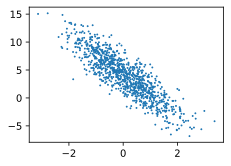

In [5]:
def use_svg_display():
    display.set_matplotlib_formats('svg')

def set_figsize(figsize=(3.5, 2.5)):
    use_svg_display()
    plt.rcParams['figure.figsize'] = figsize
set_figsize()
plt.scatter(features[:, 1].numpy(), labels.numpy(), 1)

In [6]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        j = torch.LongTensor(indices[i: min(i + batch_size, num_examples)])
        yield features.index_select(0, j), labels.index_select(0, j)

In [7]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, y)
    break

tensor([[-0.0997, -0.4045],
        [ 1.8190, -1.4777],
        [-0.5171, -0.3672],
        [-0.3436, -0.8180],
        [-0.5951, -0.2436],
        [ 0.5937, -0.0116],
        [ 0.6913, -0.5969],
        [-0.5653, -0.6496],
        [-1.4750, -0.7016],
        [-0.0097, -0.5548]]) tensor([ 5.3620, 12.8567,  4.4121,  6.2855,  3.8420,  5.4398,  7.6007,  5.2752,
         3.6375,  6.0586])


In [8]:
w = torch.tensor(np.random.normal(0, 0.01, size=(num_inputs, 1)), dtype=torch.float32)
b = torch.zeros(1, dtype=torch.float32)

w.requires_grad_(True)
b.requires_grad_(True)

tensor([0.], requires_grad=True)

In [9]:
def linereg(X, w, b):
    return torch.mm(X, w) + b

def squared_loss(y_hat, y):
    return (y_hat - y.view(y_hat.size())) ** 2 / 2

In [10]:
def sgd(params, lr, batch_size):
    for param in params:
        param.data -= lr * param.grad / batch_size

In [11]:
lr = 0.03
num_epochs = 3
net = linereg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y).sum()
        l.backward()
        sgd([w, b], lr, batch_size)

        w.grad.data.zero_()
        b.grad.data.zero_()
    train_l = loss(net(features, w, b), labels)
    print('epoch %d, loss %f' % (epoch, train_l.mean().item()))

epoch 0, loss 0.048425
epoch 1, loss 0.000198
epoch 2, loss 0.000053


In [12]:
print(true_w, '\n', w)
print(true_b, '\n', b)

[2, -3.4] 
 tensor([[ 1.9995],
        [-3.3995]], requires_grad=True)
4.2 
 tensor([4.1988], requires_grad=True)


2. 利用 torch.nn 实现线性回归在人工构造的数据集上进行训练和测试

In [13]:
import torch.utils.data as Data

batch_size = 10

dataset = Data.TensorDataset(features, labels)
data_iter = Data.DataLoader(dataset, batch_size, shuffle=True)


In [14]:
for X, y in data_iter:
    print(X, y)
    break

tensor([[ 2.0710,  0.0793],
        [-0.0031,  0.8043],
        [ 0.5441,  1.5204],
        [ 1.6638, -0.5896],
        [ 1.2578, -1.2149],
        [ 0.4380,  0.9771],
        [ 1.2227,  0.4166],
        [-0.3748, -0.3612],
        [ 0.4470,  0.7034],
        [-0.5630, -0.5981]]) tensor([ 8.0833,  1.4572,  0.1121,  9.5215, 10.8563,  1.7628,  5.2188,  4.6663,
         2.7179,  5.1142])


In [15]:
from torch import nn

# class LinearNet(nn.Module):
#     def __init__(self, n_feature):
#         super(LinearNet, self).__init__()
#         self.linear = nn.Linear(n_feature, 1)
#
#     def forward(self, x):
#         y = self.linear(x)
#         return y
#
# net = LinearNet(num_inputs)
# print(net)

In [16]:
net = nn.Sequential()
net.add_module('linear', nn.Linear(num_inputs, 1))

print(net)
print(net[0])

Sequential(
  (linear): Linear(in_features=2, out_features=1, bias=True)
)
Linear(in_features=2, out_features=1, bias=True)


In [17]:
for param in net.parameters():
    print(param)

Parameter containing:
tensor([[-0.5089, -0.5211]], requires_grad=True)
Parameter containing:
tensor([-0.1426], requires_grad=True)


In [18]:
from torch.nn import init

init.normal_(net[0].weight, mean=0, std=0.01)
init.constant_(net[0].bias, val=0)

Parameter containing:
tensor([0.], requires_grad=True)

In [19]:
loss = nn.MSELoss()

In [20]:
import torch.optim as optim

optimizer = optim.SGD(net.parameters(), lr=0.03)
print(optimizer)

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.03
    momentum: 0
    nesterov: False
    weight_decay: 0
)


In [21]:
num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter:
        output = net(X)
        l = loss(output, y.view(-1, 1))
        l.backward()
        optimizer.step()
        optimizer.zero_grad()
    # l = loss(net(features), labels.view(-1, 1))
    print('epoch %d: loss = %f' % (epoch+1, l.item()))

epoch 1: loss = 0.000179
epoch 2: loss = 0.000134
epoch 3: loss = 0.000086


In [22]:
dense = net[0]
print(true_w, dense.weight)
print(true_b, dense.bias)

[2, -3.4] Parameter containing:
tensor([[ 1.9994, -3.3990]], requires_grad=True)
4.2 Parameter containing:
tensor([4.1996], requires_grad=True)


### 三、动手实现 softmax 回归

1. 动手从 0 实现 softmax 回归（只借助于 Tensor 和 Numpy 相关的库）在 Fashion-MNIST 数据集三进行训练和测试。

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

mnist_train = torchvision.datasets.FashionMNIST(root='~/Code/Datasets/FashionMNIST', train=True, download=True, transform=transforms.ToTensor())
mnist_test = torchvision.datasets.FashionMNIST(root='~/Code/Datasets/FashionMNIST', train=False, download=True, transform=transforms.ToTensor())

In [ ]:
print(len(mnist_train))
print(len(mnist_test))

In [ ]:
import d2l_pytorch as d2l

X, y = [], []

for i in range(10):
    X.append(mnist_train[i][0])
    y.append(mnist_train[i][1])

d2l.show_fashion_mnist(X, d2l.get_fashion_mnist_labels(y))

In [ ]:
batch_size=256
num_workers = 4
train_iter = torch.utils.data.DataLoader(dataset=mnist_train, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_iter = torch.utils.data.DataLoader(dataset=mnist_test, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [ ]:
num_inputs=784
num_outputs=10

W = torch.tensor(np.random.normal(0, 0.01, size=(num_inputs, num_outputs)), dtype=torch.float)
b = torch.zeros(num_outputs, dtype=torch.float)

In [ ]:
W.requires_grad_(requires_grad=True)
b.requires_grad_(requires_grad=True)

In [ ]:
def softmax(X):
    X_exp = X.exp()
    partition = X_exp.sum(dim=1, keepdim=True)
    # print(partition.size())
    return X_exp / partition

In [ ]:
def net(X):
    return softmax(torch.mm(X.view(-1, num_inputs), W) + b)

In [ ]:
def cross_entropy(y_hat, y):
    return -torch.log(y_hat.gather(dim=1, index=y.view(-1, 1)))

In [ ]:
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y = torch.LongTensor([0, 2])
y_hat.gather(dim=1, index=y.view(-1, 1))

In [ ]:
def accuracy(y_hat, y):
    return (y_hat.argmax(dim=1) == y).float().mean().item()

In [ ]:
print(accuracy(y_hat, y))

In [ ]:
def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0.0, 0
    for X, y in data_iter:
        acc_sum += (net(X).argmax(dim=1) == y).float().mean().item()
        n += y.shape[0]
    return acc_sum / n

In [ ]:
print(evaluate_accuracy(test_iter, net))

In [ ]:
def sgd(params, lr, batch_size):
    for param in params:
        param.data -= lr * param.grad / batch_size

In [ ]:
import d2l_pytorch as d2l

num_epochs, lr = 5, 0.1


def train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size,
              params=None, lr=None, optimizer=None):
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n = 0.0, 0.0, 0
        for X, y in train_iter:
            y_hat = net(X)
            l = loss(y_hat, y).sum()

            # 梯度清零
            if optimizer is not None:
                optimizer.zero_grad()
            elif params is not None and params[0].grad is not None:
                for param in params:
                    param.grad.data.zero_()

            l.backward()

            if optimizer is None:
                sgd(params, lr, batch_size)
            else:
                optimizer.step()

            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).float().mean().item()
            n += y.shape[0]

        test_acc = evaluate_accuracy(test_iter, net)
        print('epoch #%d, loss %.4f, train acc %.3f, test acc %.3f\n' %
              (epoch + 1, train_l_sum / n, train_acc_sum / n, test_acc))

In [ ]:
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, batch_size, [W, b], lr)